# Figure 4
---

This notebook generate a purpose specific figure that illustrates the annual, quarterly, montly, and 6/12 day Sentinel 1 products. 

It is not meant to be tutorial in nature. Tutorials for the packages used to create the plots can be found [here](https://github.com/fastice/GrIMPTools).

In [10]:
#%matplotlib ipympl
%load_ext autoreload
%autoreload 2
import grimpfunc as grimp
import nisardev as nisar
import panel as pn
pn.extension()
from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=1)
import matplotlib.gridspec as gridspec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup NSIDC Access

The following code will take the users earthdata login, create a *.netrc* file, and setup the appropriate path variabiles. Once this has been accomplished, the data at NSIDC are accessible via GDAL's *vsicurl* protocal.

In [6]:
# Set path for gdal 
env = dict(GDAL_HTTP_COOKIEFILE = os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR = os.path.expanduser('~/.grimp_download_cookiejar.txt'))
os.environ.update(env)
# Get login
myLogin = grimp.NASALogin()  # If login appears not to work, try rerunning this cell
myLogin.view()

Getting login from ~/.netrc
Already logged in. Proceed.


## Product Definitions

In [7]:
products = ['S1_Annual','S1_Quarterly', 'S1_Monthly', 'S1_6day', 'TSX', 'Opt']
nsidcNames = {'S1_Annual': 'NSIDC-0725','S1_Quarterly': 'NSIDC-0727' , 'S1_Monthly': 'NSIDC-0731', 'S1_6day': 'NSIDC-0766', 'TSX': 'NSIDC-0481', 'Opt': 'NSIDC-0646'}
prodDate = {'S1_Annual': {'format': '%d%b%y', 'index1': 4, 'index2': 5, },
            'S1_Quarterly': {'format': '%d%b%y', 'index1': 4, 'index2': 5},
            'S1_Monthly': {'format': '%d%b%y', 'index1': 4, 'index2': 5},
            'S1_6day': {'format': '%d%b%y', 'index1': 4, 'index2': 5}}
prodReplace =  {'S1_Annual':  'vv',
            'S1_Quarterly':  'vv',
            'S1_Monthly': 'vv',
            'S1_6day':  'vv'}

## Get Data

Find products in catalog.

In [8]:
glacierData = {}  # Dictionary to store each set of products
# Search catalog for all products
prodFilter = {'S1_Annual': None,'S1_Quarterly': None , 'S1_Monthly': None, 'S1_6day': None}
for product in prodFilter:
    myUrls = grimp.cmrUrls(mode='nisar')  # mode image restricts search to the image products
    print(nsidcNames[product])
    myUrls.initialSearch(firstDate='2019-12-01', lastDate='2020-11-30', product=nsidcNames[product], productFilter=prodFilter[product]) 
    glacierData[f'{product}Cogs'] =  myUrls.getCogs(replace='vv', removeTiff=True)
    print(f' {product} {len(glacierData[f"{product}Cogs"])}')

NSIDC-0725
 S1_Annual 1
NSIDC-0727
 S1_Quarterly 4
NSIDC-0731
 S1_Monthly 12
NSIDC-0766
 S1_6day 62


Read data with different overview levels to reflect level of detail in figure.

In [9]:
for product, overviewLevel in zip(prodFilter, [2, 2, 3, 3]):
    print(product)
    glacierData[f'{product}Series'] = nisar.nisarVelSeries() # Create Series
    glacierData[f'{product}Series'].readSeriesFromTiff(glacierData[f'{product}Cogs']  , url=True, readSpeed=False, overviewLevel=overviewLevel) 
    glacierData[f'{product}Series'].loadRemote()

S1_Annual
[########################################] | 100% Completed |  5.2s
[########################################] | 100% Completed |  5.3s
S1_Quarterly
[########################################] | 100% Completed | 27.5s
[########################################] | 100% Completed | 27.6s
S1_Monthly
[########################################] | 100% Completed | 35.5s
[########################################] | 100% Completed | 35.5s
S1_6day
[########################################] | 100% Completed |  3min 53.6s
[########################################] | 100% Completed |  3min 53.6s


Now generate the plot for Annual, Quarterly, Monthly, and 6-day products.

57 40
S1_Annual
S1_Quarterly
S1_Monthly


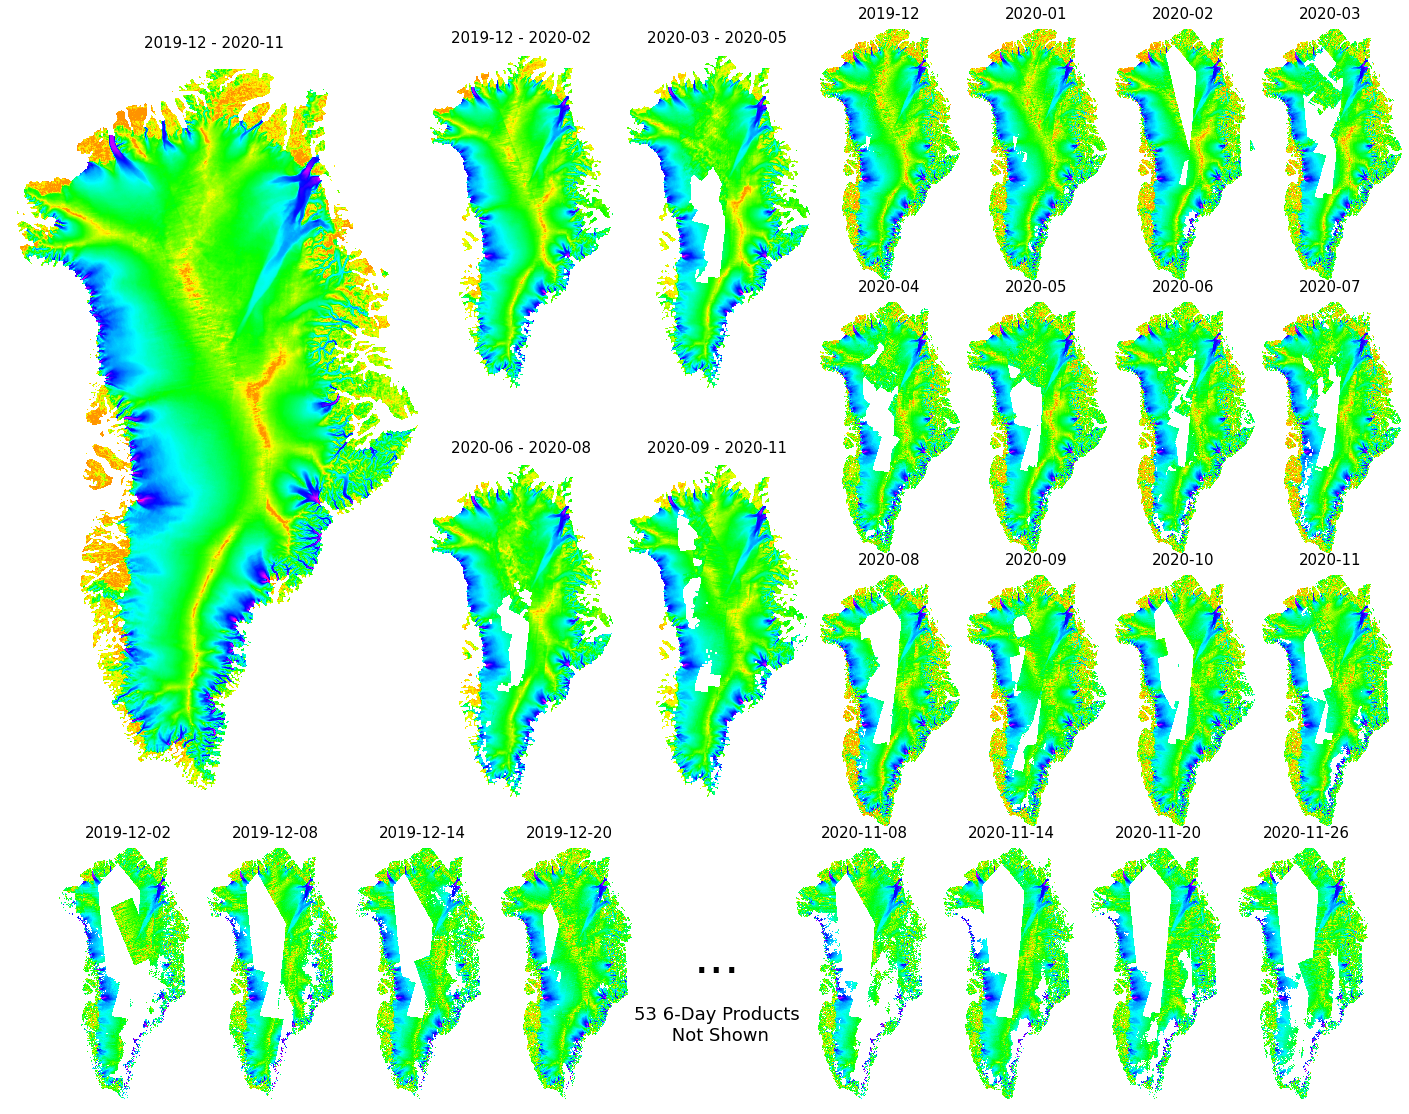

In [11]:
fig=plt.figure(figsize=(25,20))
# Setup grid sizes for grid spec
# offset, rows, columns
na = (0, 30, 17)  # Annual
nq = (na[2], 15, 8) # Quarterly
nm = (na[2] + nq[2]*2, 10, 6) # Montly
n6 = (2, 10, 6)
# Sum to get width and heigh for grid spec
nw = na[2] + nq[2] * 2 + nm[2] * 4
nh = na[1] + n6[1]
print(nw, nh)
gs = gridspec.GridSpec(nh, nw)
axes = {}
# Create a set of axes for each product type
axes['S1_Annual'] = [plt.subplot(gs[0:na[1], 0:na[2]])]
axes['S1_Quarterly'] = [plt.subplot(gs[i*nq[1]:(i+1)*nq[1], nq[0]+j*nq[2]:nq[0]+(j+1)*nq[2]]) for i in range(0,2) for j in range(0,2)]
axes['S1_Monthly'] = [plt.subplot(gs[i*nm[1]:(i+1)*nm[1], nm[0]+j*nm[2]:nm[0]+(j+1)*nm[2]]) for i in range(0,3) for j in range(0,4)]
axes['S1_6day'] = [plt.subplot(gs[na[1]+i*n6[1]:na[1]+(i+1)*n6[1], n6[0]+j*n6[2]:n6[0]+(j+1)*n6[2]]) for i in range(0,1) for j in range(0, 9)]  
#
# Plot Annual, Quarterly, and Montly products
for product, midDate, interpMethod in zip(['S1_Annual','S1_Quarterly', 'S1_Monthly'], [False, False, True], ['antialiased', 'antialiased', 'nearest']):
    print(product)
    for ax, date, date1, date2 in zip(axes[product], glacierData[f'{product}Series'].time, glacierData[f'{product}Series'].time1, glacierData[f'{product}Series'].time2):
        if product == 'S1_Monthly':
            title = date.strftime('%Y-%m')  # Just use Year/month
        else:
            title = f'{date1.strftime("%Y-%m")} - {date2.strftime("%Y-%m")}' # provide date range
        # Plot data
        glacierData[f'{product}Series'].displayVelForDate(date=date, ax=ax, colorBar=False, axisOff=True, units='m',scale='log', vmin=1, vmax=10000, interpolation=interpMethod, title=title)
# Plot subset of 6 day products
product = 'S1_6day'
# Early dates
for ax, date in zip(axes['S1_6day'][0:4], glacierData[f'{product}Series'].time[0:4] ):
    glacierData[f'{product}Series'].displayVelForDate(date=date, ax=ax, colorBar=False, axisOff=True, units='m',scale='log', vmin=1, vmax=10000, interpolation='nearest')
# Later dates
for ax, date in zip(axes['S1_6day'][-4:], glacierData[f'{product}Series'].time[-5:-1] ):
    glacierData[f'{product}Series'].displayVelForDate(date=date, ax=ax, colorBar=False, axisOff=True, units='m',scale='log', vmin=1, vmax=10000, interpolation='nearest')
# Add ... to connect two subsets
axes['S1_6day'][4].text(0.5, .5,'...', fontsize=49, ha='center')
axes['S1_6day'][4].text(0.5, .25,'53 6-Day Products\n Not Shown', fontsize=18, ha='center')
axes['S1_6day'][4].axis('off')
fig.savefig('Figure4.jpg', dpi=120, bbox_inches='tight')
#fig.tight_layout() 